In [18]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import dask.array as da
import xarray as xr
import os


from xmitgcm import open_mdsdataset
import xmitgcm
import sys
sys.path.append('/Users/tatsumonkman/3rd_party_software/ECCOv4-py')
import ecco_v4_py as ecco 


from netCDF4 import Dataset

import seawater

from analysis_package import plotting_functions
from analysis_package import open_datasets
from analysis_package import ecco_masks
from analysis_package import integrate_zonally
from analysis_package import calculate_isovol



from importlib import reload

# reload modules for prototyping...
ecco_masks = reload(ecco_masks)
plotting_functions = reload(plotting_functions)
open_datasets = reload(open_datasets)
integrate_zonally = reload(integrate_zonally)
calculate_isovol = reload(calculate_isovol)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

get_basin_name:  ['mexico'] /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data
load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['mexico'] /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data
load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 

In [11]:

######################################################################################################################
############################################# CREATE DOMAIN MASKS ####################################################
######################################################################################################################
maskW = xr.open_dataarray("generic_masks/maskW.nc")
maskS = xr.open_dataarray("generic_masks/maskS.nc")
maskC = xr.open_dataarray("generic_masks/maskC.nc")



In [4]:
######################################################################################################################
################################################### LOAD GRID ########################################################
######################################################################################################################
grid_path = "ECCO-GRID.nc"
grid = xr.open_dataset(grid_path)
cds = grid.coords.to_dataset()
grid_xmitgcm = ecco.ecco_utils.get_llc_grid(cds)

######################################################################################################################
############################################# CREATE DOMAIN MASKS ####################################################
######################################################################################################################
maskW = xr.open_dataarray("generic_masks/maskW.nc")
maskS = xr.open_dataarray("generic_masks/maskS.nc")
maskC = xr.open_dataarray("generic_masks/maskC.nc")

southern_ocean_mask_W, southern_ocean_mask_S, southern_ocean_mask_C, so_atl_basin_mask_W, so_atl_basin_mask_S, so_atl_basin_mask_C, so_indpac_basin_mask_W, so_indpac_basin_mask_S, so_indpac_basin_mask_C = ecco_masks.get_basin_masks(maskW, maskS, maskC)

baffin_mask_C = ecco.get_basin_mask("baffin",maskC)
north_mask_C = ecco.get_basin_mask("north",maskC)
hudson_mask_C = ecco.get_basin_mask("hudson",maskC)
gin_mask_C = ecco.get_basin_mask("gin",maskC)
bering_mask_C = ecco.get_basin_mask("bering",maskC)
okhotsk_mask_C = ecco.get_basin_mask("okhotsk",maskC)
atl_mask_C = ecco.get_basin_mask("atl",maskC)

# masks with low depths filtered out
so_atl_maskC_low_depth_filtered = so_atl_basin_mask_C*maskC.where(grid.Depth > 100.)
so_indpac_maskC_low_depth_filtered = so_indpac_basin_mask_C*maskC.where(grid.Depth > 100.)

atl_midlat_basin_mask_C = so_atl_basin_mask_C.where(so_atl_basin_mask_C.lat<=50,other=np.nan).where(so_atl_basin_mask_C.lat>=-32,other=np.nan)

atl_arct_basin_mask_C = so_atl_basin_mask_C.fillna(0) + ecco.get_basin_mask("arct",maskC) + ecco.get_basin_mask("barents",maskC)
atl_arct_basin_mask_C = atl_arct_basin_mask_C.where(atl_arct_basin_mask_C>0,other=np.nan)
atl_nogin_basin_mask_C = so_atl_basin_mask_C.where(so_atl_basin_mask_C.lat>-32,other=np.nan).where((gin_mask_C+north_mask_C < 1).values,other=np.nan)

get_basin_name:  ['mexico'] /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data
load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['mexico'] /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data
load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 

In [ ]:
so_atl_maskC_low_depth_filtered_noGF = so_atl_maskC_low_depth_filtered.copy()
so_atl_maskC_low_depth_filtered_noGF.loc[{"tile":10}][30:74,40:60] = np.nan
so_atl_maskC_low_depth_filtered_noGF.loc[{"tile":10}][65:76,45:55] = np.nan
so_atl_maskC_low_depth_filtered_noGF.loc[{"tile":10}][30:60,50:65] = np.nan



# Calculate the tendency..

In [13]:
SIGMA2_yrly = xr.open_dataarray("SIGMA2_yearly.nc")
SIGMA2_yrly = SIGMA2_yrly.assign_coords({"time":np.arange(0,26)})

In [20]:
# Pdens levels to interpolate to
sigma2_lvls = np.arange(1036.8,1037.24,0.01)
out_dir = "Mixing_Diags"
SIGMA2 = xr.open_dataarray(f"{out_dir}/SIGMA2_full.nc")

In [15]:
SALT_means = xr.open_dataset(f"Mixing_Diags/SALT_full.nc")
delta_t = (SALT_means.time_bnds.diff("nv") / np.timedelta64(1, 's')).copy()
delta_t_snaps = delta_t.isel(nv=0).copy()

so_indpac_basin_mask_C = so_indpac_basin_mask_C.assign_coords(maskC.coords)
indpac_basin_mask_C = so_indpac_basin_mask_C.where(so_indpac_basin_mask_C.lat >-33,other=np.nan)

SO_sig_mask = xr.open_dataarray("SO_sig_mask.nc")

In [46]:
vol_sig2s = []
dvoldt_sig2s = []
dvoldt_sig2_means = []

do_calc_isovols = False

sigma2_lvls = np.arange(1036.8,1037.24,0.005)

if do_calc_isovols == True:
    for year in [0,25]:
        print(year)
        vol_sig2_interp_out = calculate_isovol.calculate_isovol(grid,SIGMA2,
                                                                maskC,sigma2_lvls,
                                                                time_slice=np.arange(year*12,year*12+12),
                                                                subset_tseries=False,save=False,
                                                                label="2_monthly",make_sigmax_arr=False,
                                                                interp=True)
        vol_sig2_interp_out.to_netcdf(f"{out_dir}/vol_005res_SIGMA2_year_{year}_out.nc")
        
else:
    for year in [0,25]:
        print(year)
        vsig2_yr = xr.open_dataarray(f"{out_dir}/vol_005res_SIGMA2_year_{year}_out.nc")
        vsig2_yr.name = "Volume"
        vol_sig2s.append(vsig2_yr)
        
        dvoldt_sig2 = vsig2_yr.copy().diff("time")/delta_t_snaps.isel(time=np.arange(12*year,12*year+12))
        
        dvoldt_sig2s.append(dvoldt_sig2)
        dvoldt_sig2_means.append(dvoldt_sig2.mean(dim="time"))
    


0
25


In [30]:
lowres_vol_sig2s = []
lowres_dvoldt_sig2s = []
lowres_dvoldt_sig2_means = []


for year in [0,25]:
    print(year)
    vsig2_yr = xr.open_dataarray(f"{out_dir}/vol_SIGMA2_year_{year}_out.nc")
    vsig2_yr.name = "Volume"
    lowres_vol_sig2s.append(vsig2_yr)

    dvoldt_sig2 = vsig2_yr.copy().diff("time")/delta_t_snaps.isel(time=np.arange(12*year,12*year+12))

    lowres_dvoldt_sig2s.append(dvoldt_sig2)
    lowres_dvoldt_sig2_means.append(dvoldt_sig2.mean(dim="time"))
    



0
25


In [45]:
indpac_vol_diff_total.to_netcdf("./indpac_vol_diff_total.nc")
atl_vol_diff_total.to_netcdf("./atl_vol_diff_total.nc")

In [43]:
dvol_tot = dvoldt_sig2_means[0]/26

for i, dvol in enumerate(dvoldt_sig2_means[1:]):
    dvol_tot = dvol_tot + dvol/26
    

IndexError: The indexing operation you are attempting to perform is not valid on netCDF4.Variable object. Try loading your data into memory first by calling .load().

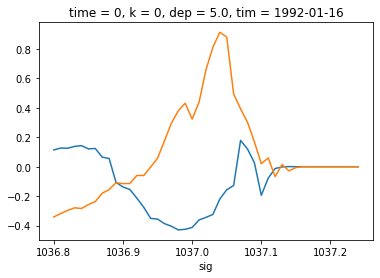

In [44]:
((dvol_tot*atl_midlat_basin_mask_C).sum(dim=["tile","j","i"])/1e6).plot()
((dvol_tot*indpac_basin_mask_C).sum(dim=["tile","j","i"])/1e6).plot()
((dvol_tot*SO_sig_mask).sum(dim=["tile","j","i"])/1e6).plot()



In [85]:
((dvol_tot*atl_midlat_basin_mask_C).sum(dim=["tile","j","i"])/1e6).to_netcdf("atl_dvol_tot.nc")
((dvol_tot*indpac_basin_mask_C).sum(dim=["tile","j","i"])/1e6).to_netcdf("indpac_dvol_tot.nc")
((dvol_tot*SO_sig_mask).sum(dim=["tile","j","i"])/1e6).to_netcdf("so_dvol_tot.nc")

In [15]:
GM_PsiY = xr.open_dataset("GM_PsiY_full.nc")
#vol_sig2_interp_out_intime = xr.open_dataarray("vol_sig2_interp_out_intime.nc")

tdiffs = (GM_PsiY.time_bnds.values[5:-6,1]-GM_PsiY.time_bnds.values[5:-6,0])/np.timedelta64(1,'s')



In [ ]:
for year in range(0,26):
    print(year)
    vsig2_yr = xr.open_dataarray(f"{out_dir}/vol_SIGMA2_year_{year}_out.nc")
    vsig2_yr.name = "Volume"
    vol_sig2s.append(vsig2_yr)




In [ ]:
vol_sig2_interp_out_first = xr_vol_sig2s.isel(time=0)
vol_sig2_interp_out_last = xr_vol_sig2s.isel(time=-1)

In [11]:
AMOC_SIGMA2 = xr.open_dataarray("AMOC_sig2.nc").mean(dim="time")
IPMOC_SIGMA2 = xr.open_dataarray("IPMOC_sig2.nc").mean(dim="time")

In [22]:
atl_maxsig_array_v4r4 = xr.open_dataarray("./atl_maxsig_array_v4r4.nc")
indpac_maxsig_array_v4r4 = xr.open_dataarray("./indpac_maxsig_array_v4r4.nc")



atl_deep_dens_maxima_overall_monosouth = np.maximum.accumulate(atl_maxsig_array_v4r4[68::-1].values)
indpac_deep_dens_maxima_overall_monosouth = np.maximum.accumulate(indpac_maxsig_array_v4r4[68::-1].values)
atl_deep_dens_maxima_overall_mononorth = np.maximum.accumulate(atl_maxsig_array_v4r4[108:].values)
indpac_deep_dens_maxima_overall_mononorth = np.maximum.accumulate(indpac_maxsig_array_v4r4[108:].values)

atl_mono_ns = atl_maxsig_array_v4r4*0
atl_mono_ns.loc[{"lat":np.arange(-88,-19)}] = np.flip(atl_deep_dens_maxima_overall_monosouth,axis=0)
atl_mono_ns.loc[{"lat":np.arange(19,88)}] = atl_deep_dens_maxima_overall_mononorth
indpac_mono_ns = indpac_maxsig_array_v4r4*0
indpac_mono_ns.loc[{"lat":np.arange(-88,-19)}] = np.flip(indpac_deep_dens_maxima_overall_monosouth,axis=0)
indpac_mono_ns.loc[{"lat":np.arange(19,88)}] = indpac_deep_dens_maxima_overall_mononorth

amoc_psi_botsurf = AMOC_SIGMA2.where(AMOC_SIGMA2.sig>atl_mono_ns)
ipmoc_psi_botsurf = IPMOC_SIGMA2.where(IPMOC_SIGMA2.sig>indpac_mono_ns)
amoc_psi_botsurf_val = amoc_psi_botsurf[(amoc_psi_botsurf.fillna(0)!=0).argmax(axis=0)]/1e6
ipmoc_psi_botsurf_val = ipmoc_psi_botsurf[(ipmoc_psi_botsurf.fillna(0)!=0).argmax(axis=0)]/1e6


amoc_botsurf = AMOC_SIGMA2.interp(sig=atl_maxsig_array_v4r4[:-1:])
ipmoc_botsurf = IPMOC_SIGMA2.interp(sig=atl_maxsig_array_v4r4[:-1:])
#amoc_psi_botsurf_noSDS = AMOC_noSDS_sig2[:,:-1:,:].interp(sig=atl_maxsig_array_v4r4.loc[{"lat":AMOC_noSDS_sig2.lat}][:-1:])







OSError: [Errno -51] NetCDF: Unknown file format: b'/Users/tatsumonkman/Dropbox/ECCO-Project/ECCOv4r4-analysis/vol_sig2_yearly_tdiff_tsum.nc'

In [15]:
# Here I calculate the stretched y-axis coordinates on which to plot my stream functions. Defining them using the average
# depth of isopycnals in the Atlantic Ocean
dpth_lat_path = "./"
atl_pdens2_in_depth_lat = xr.open_dataarray(dpth_lat_path+"SIGMA2_atl_lat_means.nc").mean(dim="time").loc[{"lat":np.arange(-32,35)}]
atl_pdens2_mean = grid.Z.assign_coords({"k":atl_pdens2_in_depth_lat.mean(dim="lat").values})
atl_pdens2_mean_lvls = atl_pdens2_mean.interp(k=AMOC_SIGMA2.sig)
# extend atl_pdens2_mean_lvls to the ocean bottom
atl_pdens2_mean_lvls[-24:] = np.arange(-6000,atl_pdens2_mean_lvls[-25].values,60)[-1::-1]
atl_pdens2_mean_lvls[:2] = [0,-10]

atl_botsurf_depthlvl = atl_pdens2_mean_lvls.interp(sig=atl_maxsig_array_v4r4)
ipmoc_botsurf_depthlvl = atl_pdens2_mean_lvls.interp(sig=indpac_maxsig_array_v4r4)



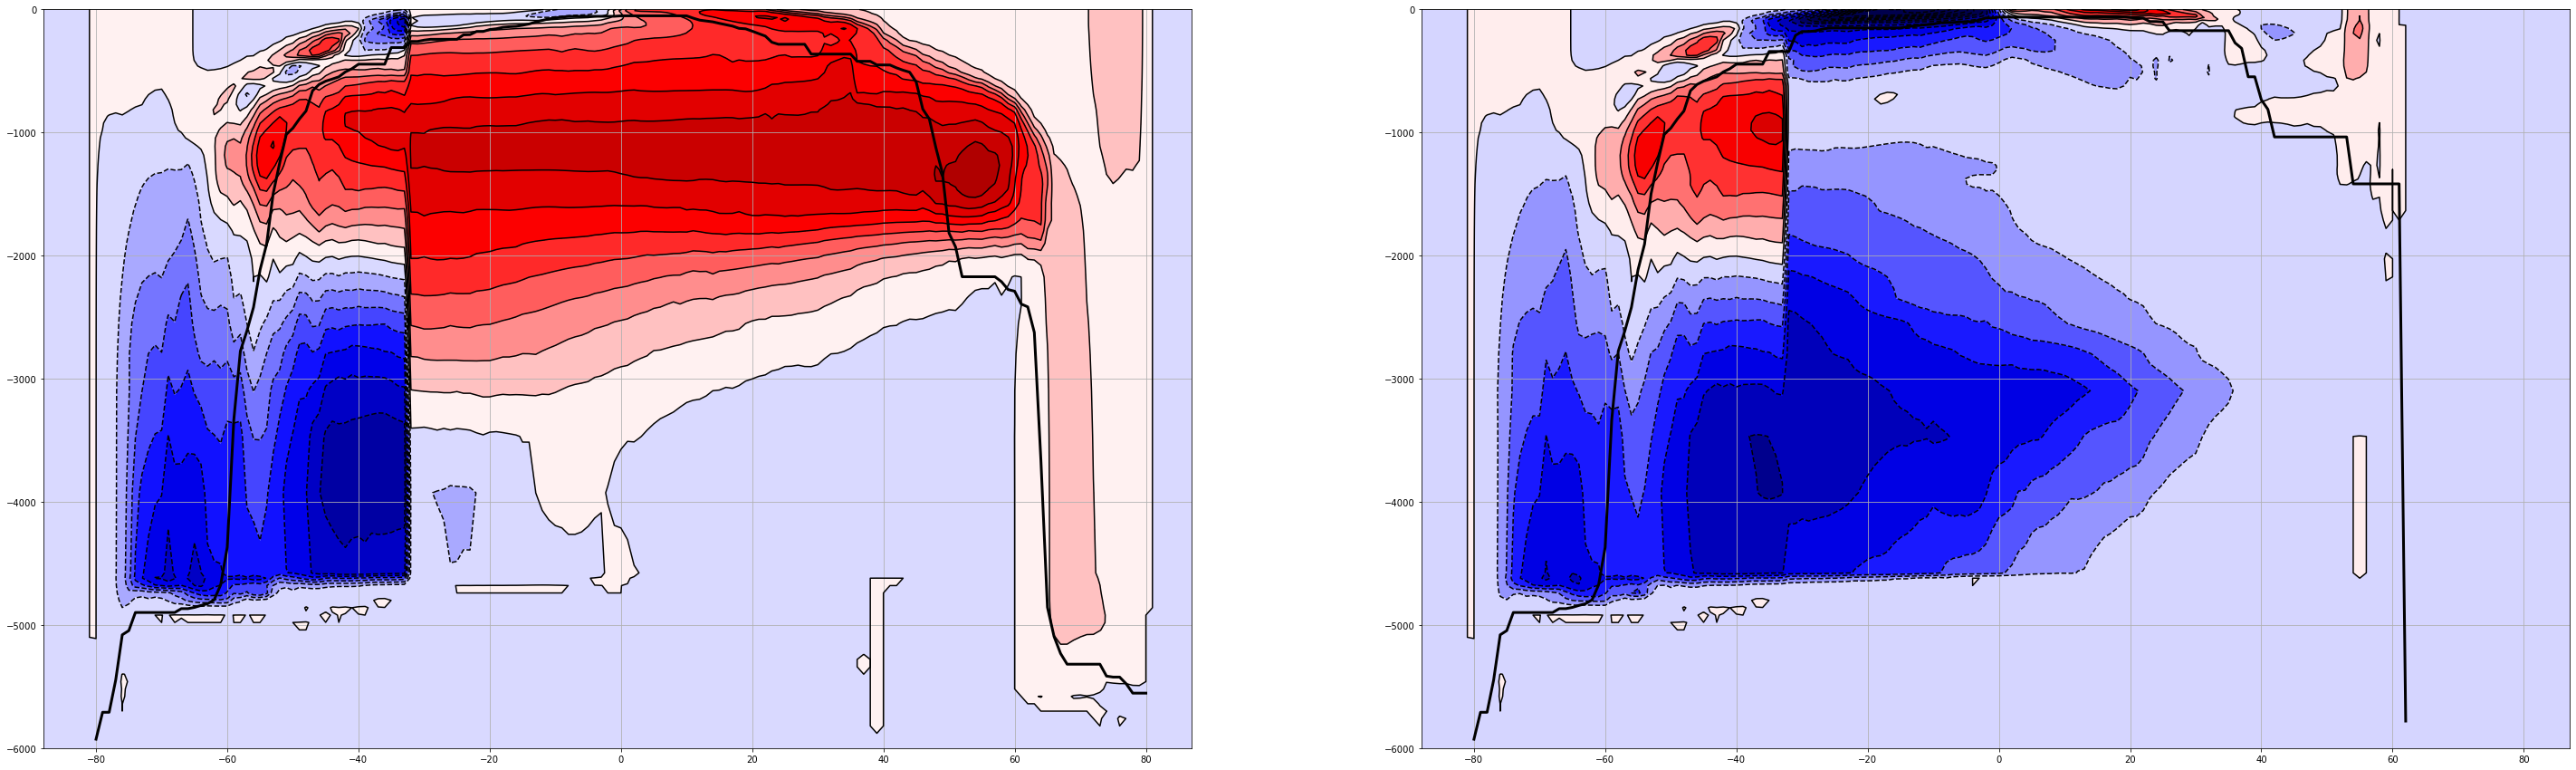

In [16]:
fig = plt.figure(figsize=(50,15))
gs = gridspec.GridSpec(nrows=1,ncols=2)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

ax0.contourf(amoc_psi_botsurf.lat,atl_pdens2_mean_lvls,AMOC_SIGMA2/1e6,cmap="seismic",vmin=-20,vmax=21,levels=20)
ax0.contour(amoc_psi_botsurf.lat,atl_pdens2_mean_lvls,AMOC_SIGMA2/1e6,colors="k",vmin=-20,vmax=21,levels=20)
ax0.plot(atl_botsurf_depthlvl.lat,atl_botsurf_depthlvl,linewidth=3,color="k")
ax0.grid()
ax1.contourf(ipmoc_psi_botsurf.lat,atl_pdens2_mean_lvls,IPMOC_SIGMA2/1e6,cmap="seismic",vmin=-20,vmax=21,levels=20)
ax1.contour(ipmoc_psi_botsurf.lat,atl_pdens2_mean_lvls,IPMOC_SIGMA2/1e6,colors="k",vmin=-20,vmax=21,levels=20)
ax1.plot(ipmoc_botsurf_depthlvl.lat,ipmoc_botsurf_depthlvl,linewidth=3,color="k")
ax1.grid()

plt.show()
plt.close()

In [17]:
dvolume_tdiff = (vol_sig2_interp_out_last-vol_sig2_interp_out_first)/tdiffs[6:-6].sum(dim="time")

In [19]:
atl_nogin_basin_mask_C = so_atl_basin_mask_C.where(so_atl_basin_mask_C.lat>-32,other=np.nan).where((gin_mask_C+north_mask_C < 1).values,other=np.nan)
indpac_basin_mask_C = so_indpac_basin_mask_C.where(so_indpac_basin_mask_C.lat >= -32)
so_basin_mask_C = so_atl_basin_mask_C.where(so_atl_basin_mask_C.lat <= -32)


atl_vol_SIGMA2_tdiff_tsum_surf = dvolume_tdiff.copy()*atl_nogin_basin_mask_C
indpac_vol_SIGMA2_tdiff_tsum_surf = dvolume_tdiff.copy()*indpac_basin_mask_C
so_vol_SIGMA2_tdiff_tsum_surf = dvolume_tdiff.copy()*so_basin_mask_C



In [20]:

def find_vol_psi_surf_atlN(max_sig,atl_vol_SIGMA2_tdiff_tsum,delta_T):
    atl_maskC_sanity =  atl_vol_SIGMA2_tdiff_tsum*0+1
    for lat in np.arange(35,88):
        print(lat,end=" ")
        sig_lat_max = max_sig.where(max_sig.lat>=lat).min()
        print(sig_lat_max)
        surf_mask = atl_vol_SIGMA2_tdiff_tsum.where(((atl_vol_SIGMA2_tdiff_tsum.sig >= sig_lat_max) & (maskC.lat >= lat) | ( so_atl_basin_mask_C.lat < lat)),other=np.nan)*0+1
        
        atl_maskC_sanity = atl_maskC_sanity*surf_mask.fillna(0)

    atl_vol_psi_surf = ((atl_vol_SIGMA2_tdiff_tsum)*atl_maskC_sanity).sum(dim=["tile","i","j"])
    atl_vol_psi_nosurf = (atl_vol_SIGMA2_tdiff_tsum).sum(dim=["tile","i","j"])

    return atl_vol_psi_surf, atl_vol_psi_nosurf, atl_maskC_sanity



def find_vol_psi_surf_atlS(max_sig,so_vol_SIGMA2_tdiff_tsum,delta_T):
    so_vol_SIGMA2_tdiff_tsum_surf = so_vol_SIGMA2_tdiff_tsum
    maskC_sanity =  so_vol_SIGMA2_tdiff_tsum*0+1
    # in the Southern Hemisphere
    for lat in np.arange(-76,-31):
        print(lat, end=" ")
        sig_lat_max = max_sig.where(max_sig.lat<=lat).min()
        surf_mask = so_vol_SIGMA2_tdiff_tsum.where(((so_vol_SIGMA2_tdiff_tsum.sig >= sig_lat_max) & (so_atl_basin_mask_C.lat <= lat) | ( so_atl_basin_mask_C.lat > lat)),other=np.nan)*0+1

        so_vol_SIGMA2_tdiff_tsum_surf = so_vol_SIGMA2_tdiff_tsum_surf*surf_mask.fillna(0)
        maskC_sanity = maskC_sanity*surf_mask.fillna(0)

    so_vol_psi_surf = so_vol_SIGMA2_tdiff_tsum_surf.sum(dim=["tile","i","j"])
    so_vol_psi_nosurf = so_vol_SIGMA2_tdiff_tsum.sum(dim=["tile","i","j"])

    return so_vol_psi_surf, so_vol_psi_nosurf, maskC_sanity

  
atl_vol_psi_surf, atl_vol_psi_nosurf, atl_maskC_sanity = find_vol_psi_surf_atlN(atl_maxsig_array_v4r4,atl_vol_SIGMA2_tdiff_tsum_surf,tdiffs[6:-6].sum(dim="time"))
atl_vol_psi_surf.to_netcdf("atl_vol_psi_surf.nc")
atl_vol_psi_nosurf.to_netcdf("atl_vol_psi_nosurf.nc")

so_vol_psi_surf, so_vol_psi_nosurf, maskC_sanity = find_vol_psi_surf_atlS(atl_maxsig_array_v4r4,vol_sig2_yearly_tdiff_tsum*so_basin_mask_C,tdiffs[6:-6].sum(dim="time"))
so_vol_psi_surf.to_netcdf("so_vol_psi_surf.nc")
so_vol_psi_nosurf.to_netcdf("so_vol_psi_nosurf.nc")




35 <xarray.DataArray ()>
array(1035.57784606)
36 <xarray.DataArray ()>
array(1035.717753)
37 <xarray.DataArray ()>
array(1035.717753)
38 <xarray.DataArray ()>
array(1035.717753)
39 <xarray.DataArray ()>
array(1035.78138506)
40 <xarray.DataArray ()>
array(1035.78138506)
41 <xarray.DataArray ()>
array(1035.78281874)
42 <xarray.DataArray ()>
array(1035.8310168)
43 <xarray.DataArray ()>
array(1035.86964575)
44 <xarray.DataArray ()>
array(1035.90228682)
45 <xarray.DataArray ()>
array(1036.04691142)
46 <xarray.DataArray ()>
array(1036.34369603)
47 <xarray.DataArray ()>
array(1036.4208801)
48 <xarray.DataArray ()>
array(1036.60868834)
49 <xarray.DataArray ()>
array(1036.73614591)
50 <xarray.DataArray ()>
array(1036.90361979)
51 <xarray.DataArray ()>
array(1036.92477121)
52 <xarray.DataArray ()>
array(1036.95980603)
53 <xarray.DataArray ()>
array(1036.95980603)
54 <xarray.DataArray ()>
array(1036.95980603)
55 <xarray.DataArray ()>
array(1036.95980603)
56 <xarray.DataArray ()>
array(1036.959806

NameError: name 'vol_sig2_yearly_tdiff_tsum' is not defined

In [80]:
atl_vol_SIGMA2_tdiff_tsum_surf = dvolume_tdiff.copy()*atl_nogin_basin_mask_C
indpac_vol_SIGMA2_tdiff_tsum_surf = dvolume_tdiff.copy()
so_vol_SIGMA2_tdiff_tsum_surf = dvolume_tdiff.copy()*so_basin_mask_C

for lat in np.arange(35,88):
    print(lat, end=" ")
    atl_vol_SIGMA2_tdiff_tsum_surf = atl_vol_SIGMA2_tdiff_tsum_surf.where((atl_vol_SIGMA2_tdiff_tsum_surf.sig >= atl_maxsig_array.loc[{"lat":lat}]) & (so_atl_basin_mask_C.lat >= lat) | ( so_atl_basin_mask_C.lat < lat), other=0)
    indpac_vol_SIGMA2_tdiff_tsum_surf = indpac_vol_SIGMA2_tdiff_tsum_surf.where((indpac_vol_SIGMA2_tdiff_tsum_surf.sig >= indpac_maxsig_array.loc[{"lat":lat}]) & (so_indpac_basin_mask_C.lat >= lat) | ( so_indpac_basin_mask_C.lat < lat), other=0)



35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 

# Find psi at the bottom of the surface layer!

In [222]:
amoc_psi_botsurf_val_smooth_S = []
amoc_psi_botsurf_val_smooth_pot_rho_S = []
amoc_S_lats = []
for i in np.arange(10,88):
    if amoc_psi_botsurf_val.sig[i] == amoc_psi_botsurf_val.sig[i-1]:
        pass
    else:
        amoc_psi_botsurf_val_smooth_S.append(amoc_psi_botsurf_val[i])
        amoc_psi_botsurf_val_smooth_pot_rho_S.append(amoc_psi_botsurf_val.sig[i])
        amoc_S_lats.append(amoc_psi_botsurf_val.lat[i])
        
ipmoc_psi_botsurf_val_smooth_S = []
ipmoc_psi_botsurf_val_smooth_pot_rho_S = []
ipmoc_S_lats = []
for i in np.arange(10,88):
    if ipmoc_psi_botsurf_val.sig[i] == ipmoc_psi_botsurf_val.sig[i-1]:
        pass
    else:
        ipmoc_psi_botsurf_val_smooth_S.append(ipmoc_psi_botsurf_val[i])
        ipmoc_psi_botsurf_val_smooth_pot_rho_S.append(ipmoc_psi_botsurf_val.sig[i])
        ipmoc_S_lats.append(ipmoc_psi_botsurf_val.lat[i])

amoc_psi_botsurf_val_smooth_N = []
amoc_psi_botsurf_val_smooth_pot_rho_N = []
amoc_N_lats = []
for i in np.arange(108,171):
    if amoc_psi_botsurf_val.sig[i] == amoc_psi_botsurf_val.sig[i+1]:
        pass
    else:
        amoc_psi_botsurf_val_smooth_N.append(amoc_psi_botsurf_val[i])
        amoc_psi_botsurf_val_smooth_pot_rho_N.append(amoc_psi_botsurf_val.sig[i])
        amoc_N_lats.append(amoc_psi_botsurf_val.lat[i])

ipmoc_psi_botsurf_val_smooth_N = []
ipmoc_psi_botsurf_val_smooth_pot_rho_N = []
ipmoc_N_lats = []
for i in np.arange(120,159):
    if ipmoc_psi_botsurf_val.sig[i] == ipmoc_psi_botsurf_val.sig[i+1]:
        pass
    else:
        ipmoc_psi_botsurf_val_smooth_N.append(ipmoc_psi_botsurf_val[i])
        ipmoc_psi_botsurf_val_smooth_pot_rho_N.append(ipmoc_psi_botsurf_val.sig[i])
        ipmoc_N_lats.append(ipmoc_psi_botsurf_val.lat[i])

In [304]:
amoc_N_dict = {"psi":[],"sig2":[]}
amoc_S_dict = {"psi":[],"sig2":[]}
ipmoc_N_dict = {"psi":[],"sig2":[]}
ipmoc_S_dict = {"psi":[],"sig2":[]}

for i, da in enumerate(amoc_psi_botsurf_val_smooth_N):
    amoc_N_dict["psi"].append(da.values)
    amoc_N_dict["sig2"].append(amoc_psi_botsurf_val_smooth_pot_rho_N[i].values)
    
for i, da in enumerate(amoc_psi_botsurf_val_smooth_S):
    amoc_S_dict["psi"].append(da.values)
    amoc_S_dict["sig2"].append(amoc_psi_botsurf_val_smooth_pot_rho_S[i].values)
    
for i, da in enumerate(ipmoc_psi_botsurf_val_smooth_N):
    ipmoc_N_dict["psi"].append(da.values)
    ipmoc_N_dict["sig2"].append(ipmoc_psi_botsurf_val_smooth_pot_rho_N[i].values)
    
for i, da in enumerate(ipmoc_psi_botsurf_val_smooth_S):
    ipmoc_S_dict["psi"].append(da.values)
    ipmoc_S_dict["sig2"].append(ipmoc_psi_botsurf_val_smooth_pot_rho_S[i].values)    
    
    

In [306]:
amoc_N_da = xr.DataArray(data=amoc_N_dict["psi"],
                       dims=["sig2"],
                       coords=dict(sig2=(["sig2"],amoc_N_dict["sig2"])))
amoc_S_da = xr.DataArray(data=amoc_S_dict["psi"][::-1],
                       dims=["sig2"],
                       coords=dict(sig2=(["sig2"],amoc_S_dict["sig2"][::-1])))

ipmoc_N_da = xr.DataArray(data=ipmoc_N_dict["psi"],
                       dims=["sig2"],
                       coords=dict(sig2=(["sig2"],ipmoc_N_dict["sig2"])))
ipmoc_S_da = xr.DataArray(data=ipmoc_S_dict["psi"][::-1],
                       dims=["sig2"],
                       coords=dict(sig2=(["sig2"],ipmoc_S_dict["sig2"][::-1])))


amoc_S_da = xr.concat([amoc_S_da[:25],amoc_S_da[27:]],dim="sig2")
ipmoc_S_da = xr.concat([ipmoc_S_da[:25],ipmoc_S_da[27:]],dim="sig2")



amoc_N_da = amoc_N_da.interp(sig2=so_vol_psi_surf.sig)
amoc_S_da = amoc_S_da.interp(sig2=so_vol_psi_surf.sig)
ipmoc_N_da = ipmoc_N_da.interp(sig2=so_vol_psi_surf.sig)
ipmoc_S_da = ipmoc_S_da.interp(sig2=so_vol_psi_surf.sig)

# save everything!

In [313]:
# bottom of surf transport
amoc_N_da.name = "amoc_N"
amoc_S_da.name = "amoc_S"
ipmoc_N_da.name = "ipmoc_N"
ipmoc_S_da.name = "ipmoc_S"

# volume change transport
indpac_vol_psi = indpac_vol_SIGMA2_tdiff_tsum_surf.sum(dim=["tile","i","j"])
indpac_vol_psi.name = "indpac_vol_psi"
so_vol_psi_surf.name = "so_vol_psi_surf"
so_vol_psi_nosurf.name = "so_vol_psi_nosurf"
atl_vol_psi_surf.name = "atl_vol_psi_surf"
atl_vol_psi_nosurf.name = "atl_vol_psi_nosurf"



bot_surf_ds = xr.merge([amoc_N_da,amoc_S_da[::-1],ipmoc_N_da,ipmoc_S_da[::-1]])
vol_psi_ds = xr.merge([indpac_vol_psi,so_vol_psi_surf,so_vol_psi_nosurf,atl_vol_psi_surf,atl_vol_psi_nosurf])


bot_surf_ds.to_netcdf("psis_bottom_of_surf.nc")
vol_psi_ds.to_netcdf("vol_psi_ds.nc")
